In [1]:
import torch
from torch import nn

import glob
import os
from tqdm import tqdm
from datetime import datetime
import json
import yaml

from argparse import ArgumentParser

from itertools import combinations
import warnings

import torchvision
from torchvision.transforms import v2
from torchvision import tv_tensors
from torchvision import models

import torch.nn.functional as F

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.base import (
    ClassificationHead,
    SegmentationHead,
    SegmentationModel,
)

from segmentation_models_pytorch.base import modules as md

from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base.hub_mixin import supports_config_loading
from typing import Any, Dict, Optional, Union, Callable, Sequence, List, Literal

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger, Logger

from torchmetrics import classification
from torchmetrics import segmentation

from sklearn.model_selection import train_test_split
from sklearn import metrics

import numpy as np

import pandas as pd

c:\Users\mokhail\miniconda3\envs\deep_learning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Работа с данными

In [3]:
# datasets
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_dataset_root:str, samples_df:pd.DataFrame, channel_indices:list, transforms:v2._transform.Transform, dtype:torch.dtype, device:torch.device):
        '''
        In:
            path_to_dataset_root - путь до корневой папки с датасетом
            samples_df - pandas.DataFrame с информацией о файлах
            channel_indices - список с номерами каналов мультиспектрального изображения
            transforms - аугментация изображений
        '''
        super().__init__()

        self.path_to_dataset_root = path_to_dataset_root
        self.samples_df = samples_df
        self.specter_bands_list = [i for i in channel_indices if isinstance(i, int)]
        self.specter_indices_names = [s for s in channel_indices if isinstance(s, str)]
        self.dtype_trasform = v2.ToDtype(dtype=dtype, scale=True)
        self.other_transforms = transforms
        self.device = device

    def __len__(self):
        return len(self.samples_df)
    @staticmethod
    def compute_spectral_index(index_name, image):
        if index_name.lower() == 'ndvi':
            b0 = image[7] # NIR, B8
            b1 = image[3] # RED, B4
            
        elif index_name.lower() == 'ndbi':
            b0 = image[10] #SWIR, B11
            b1 = image[7] #NIR, B8

        elif index_name.lower() == 'ndwi':
            b0 = image[2] #green, B3
            b1 = image[7] #NIR, B8

        elif index_name.lower() == 'ndre':
            b0 = image[7] #NIR, B8
            b1 = image[5] #Red Edge, B6
        
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            index = (b0 - b1)/(b0 + b1)
            
        index = np.nan_to_num(index, nan=-5)

        return index
            

    def __getitem__(self, idx):
        sample = self.samples_df.iloc[idx]

        file_name = sample['file_name']

        path_to_image = os.path.join(self.path_to_dataset_root, 'images', f'{file_name}.npy')
        path_to_labels = os.path.join(self.path_to_dataset_root, 'labels', f'{file_name}.npy')

        image = np.load(path_to_image)
        spectral_indices = []
        # вычисляем спектральные индексы
        if len(self.specter_indices_names) > 0:
            for sp_index_name in self.specter_indices_names:
                spectral_index = self.compute_spectral_index(sp_index_name, image)
                spectral_index = torch.as_tensor(spectral_index)
                spectral_indices.append(spectral_index.unsqueeze(0))

            spectral_indices = torch.cat(spectral_indices)
            spectral_indices = self.dtype_trasform(spectral_indices)


        image = torch.as_tensor(image[self.specter_bands_list], dtype=torch.int16)
        image = self.dtype_trasform(image)
        # добавляем спектральные индексы
        if len(self.specter_indices_names) > 0:
            image = torch.cat([image, spectral_indices], dim=0) 
        #image = np.load(path_to_image)
        # метки читаем как одноканальное изображение
        label = np.load(path_to_labels)
        label = np.where(label >= 0, label, 0)
        #label = torch.as_tensor(np.load(path_to_labels), dtype=torch.uint8).long()
        label = torch.as_tensor(label, dtype=torch.uint8).long()
        
        image = tv_tensors.Image(image, device=self.device)
        label = tv_tensors.Mask(label, device=self.device)

        transforms_dict = {'image':image, 'mask':label}
        transformed = self.other_transforms(transforms_dict)
        return transformed['image'], transformed['mask']#, image

# Описание модуля Lightning

In [4]:
def compute_pred_mask(pred):
    '''
    Определение маски классов на основе сгенерированной softmax маски
    '''
    #pred = pred.detach()
    _, pred_mask = pred.max(dim=1)
    return pred_mask#.cpu().numpy()

class SegmentationModule(L.LightningModule):
    def __init__(self, model:nn.Module, criterion:nn.Module, optimizer_cfg:dict, metrics_dict:dict, name2class_idx_dict:dict) -> None:
        '''
        Модуль Lightning для обучения сегментационной сети
        In:
            model - нейронная сеть
            criterion - функция потерь
            
            name2class_idx_dict - словарь с отображением {class_name(str): class_idx(int)}
        '''
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer_cfg = optimizer_cfg
        self.metrics_dict = metrics_dict
        
        self.name2class_idx_dict = name2class_idx_dict
        # словарь, выполняющий обратное отображение class_idx в class_name
        self.class_idx2name_dict = {v:k for k, v in name2class_idx_dict.items()}
        
    def configure_optimizers(self):
        optimizer = self.optimizer_cfg['optmizer'](self.parameters(), **self.optimizer_cfg['optimizer_args'])
        ret_dict = {'optimizer': optimizer}
        if self.optimizer_cfg['lr_scheduler'] is not None:
            scheduler = self.optimizer_cfg['lr_scheduler'](optimizer, **self.optimizer_cfg['lr_scheduler_args'])
            ret_dict['lr_scheduler'] = {'scheduler': scheduler}
            ret_dict['lr_scheduler'].update(self.optimizer_cfg['lr_scheduler_params'])
        
        return ret_dict

    def compute_metrics(self, pred_labels, true_labels, mode):
        metrics_names_list = self.metrics_dict[mode].keys()
        for metric_name in metrics_names_list:
            if 'dice' in metric_name.lower():
                self.metrics_dict[mode][metric_name].update(pred_labels, true_labels)
            else:
                self.metrics_dict[mode][metric_name].update(pred_labels.reshape(-1), true_labels.reshape(-1))
        
    
    def training_step(self, batch, batch_idx):
        data, true_labels = batch
        pred = self.model(data)
        loss = self.criterion(pred, true_labels)
        # вычисление сгенерированной маски
        pred_labels = compute_pred_mask(pred)
        #true_labels = true_labels.detach().cpu().numpy()
        
        self.compute_metrics(pred_labels=pred_labels, true_labels=true_labels, mode='train')

        # т.к. мы вычисляем общую ошибку на всей эпохе, то записываем в лог только значение функции потерь
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        data, true_labels = batch
        pred = self.model(data)
        loss = self.criterion(pred, true_labels)
        pred_labels = compute_pred_mask(pred)
        self.compute_metrics(pred_labels=pred_labels, true_labels=true_labels, mode='val')
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def log_metrics(self, mode):
        for metric_name, metric in self.metrics_dict[mode].items():
            metric_val = metric.compute()
            if 'confusion' in metric_name.lower():
                disp_name = f'{mode}_{metric_name}'
                self.log(disp_name, metric_val.cpu().tolist(), on_step=False, on_epoch=True, prog_bar=False)
            else:
                for i, value in enumerate(metric_val):
                    class_name = self.class_idx2name_dict[i]
                    disp_name = f'{mode}_{metric_name}_{class_name}'
                    self.log(disp_name, value, on_step=False, on_epoch=True, prog_bar=True)
                disp_name = f'{mode}_{metric_name}_mean'
                self.log(disp_name, metric_val.mean(), on_step=False, on_epoch=True, prog_bar=True)
            self.metrics_dict[mode][metric_name].reset()

    def on_train_epoch_end(self):
        '''
        Декодирование результатов тренировочной эпохи и запись их в лог
        '''
        self.log_metrics(mode='train')
 
    def on_validation_epoch_end(self):
        '''
        Декодирование результатов тестовой эпохи и запись их в лог
        (работает точно также, как и )
        '''
        self.log_metrics(mode='val')




# Новые функции потерь (Dice-Crossentropy)

In [5]:
class DiceCELoss(nn.Module):
    def __init__(
            self,
            ce_weight,
            ce_ignore_index,
            ce_reducion,
            ce_label_smoothing,
            dice_mode,
            dice_classes,
            dice_log_loss,
            dice_from_logits,
            dice_smooth,
            dice_ignore_index,
            dice_eps,
            losses_weight: List = [0.5, 0.5],
            is_trainable_weights: bool = False,
            weights_processing_type: str = None,
            ):
        super().__init__()
        self.dice = smp.losses.DiceLoss(
            mode=dice_mode,
            classes=dice_classes,
            log_loss=dice_log_loss,
            from_logits=dice_from_logits,
            smooth=dice_smooth,
            ignore_index=dice_ignore_index,
            eps=dice_eps
            )
        self.ce = nn.CrossEntropyLoss(
            weight=ce_weight,
            ignore_index=ce_ignore_index,
            reduction=ce_reducion,
            label_smoothing=ce_label_smoothing,
        )
        self.loss_weights = torch.tensor(losses_weight)
        if is_trainable_weights:
            self.loss_weights = nn.Parameter(self.loss_weights)
        self.weights_processing_type = weights_processing_type

    def forward(self, pred, true):
        weights = self.loss_weights
        if self.weights_processing_type == 'softmax':
            weights = weights.softmax(dim=0)
        elif self.weights_processing_type == 'sigmoid':
            weights = weights.softmax(dim=0)

        ce_loss = self.ce(pred, true) * weights[0]
        dice_loss = self.dice(pred, true) * weights[1]
        return ce_loss + dice_loss

# Адаптация FPN

In [26]:
class FPNMod(SegmentationModel):
    """FPN_ is a fully convolution neural network for image semantic segmentation.

    Args:
        encoder_name: Name of the classification model that will be used as an encoder (a.k.a backbone)
            to extract features of different spatial resolution
        encoder_depth: A number of stages used in encoder in range [3, 5]. Each stage generate features
            two times smaller in spatial dimensions than previous one (e.g. for depth 0 we will have features
            with shapes [(N, C, H, W),], for depth 1 - [(N, C, H, W), (N, C, H // 2, W // 2)] and so on).
            Default is 5
        encoder_weights: One of **None** (random initialization), **"imagenet"** (pre-training on ImageNet) and
            other pretrained weights (see table with available weights for each encoder_name)
        decoder_pyramid_channels: A number of convolution filters in Feature Pyramid of FPN_
        decoder_segmentation_channels: A number of convolution filters in segmentation blocks of FPN_
        decoder_merge_policy: Determines how to merge pyramid features inside FPN. Available options are **add**
            and **cat**
        decoder_dropout: Spatial dropout rate in range (0, 1) for feature pyramid in FPN_
        decoder_interpolation: Interpolation mode used in decoder of the model. Available options are
            **"nearest"**, **"bilinear"**, **"bicubic"**, **"area"**, **"nearest-exact"**. Default is **"nearest"**.
        in_channels: A number of input channels for the model, default is 3 (RGB images)
        classes: A number of classes for output mask (or you can think as a number of channels of output mask)
        activation: An activation function to apply after the final convolution layer.
            Available options are **"sigmoid"**, **"softmax"**, **"logsoftmax"**, **"tanh"**, **"identity"**,
            **callable** and **None**. Default is **None**.
        upsampling: Final upsampling factor. Default is 4 to preserve input-output spatial shape identity
        aux_params: Dictionary with parameters of the auxiliary output (classification head). Auxiliary output is build
            on top of encoder if **aux_params** is not **None** (default). Supported params:
                - classes (int): A number of classes
                - pooling (str): One of "max", "avg". Default is "avg"
                - dropout (float): Dropout factor in [0, 1)
                - activation (str): An activation function to apply "sigmoid"/"softmax"
                    (could be **None** to return logits)
        kwargs: Arguments passed to the encoder class ``__init__()`` function. Applies only to ``timm`` models. Keys with ``None`` values are pruned before passing.

    Returns:
        ``torch.nn.Module``: **FPN**

    .. _FPN:
        http://presentations.cocodataset.org/COCO17-Stuff-FAIR.pdf

    """

    @supports_config_loading
    def __init__(
        self,
        encoder_name: str = "resnet34",
        encoder_depth: int = 5,
        encoder_weights: Optional[str] = "imagenet",
        encoder_type:str = 'conv',
        decoder_pyramid_channels: int = 256,
        decoder_segmentation_channels: int = 128,
        decoder_merge_policy: str = "add",
        decoder_dropout: float = 0.2,
        decoder_interpolation: str = "nearest",
        in_channels: int = 3,
        classes: int = 1,
        activation: Optional[str] = None,
        upsampling: int = 4,
        aux_params: Optional[dict] = None,
        **kwargs: dict[str, Any],
    ):
        super().__init__()

        # validate input params
        if encoder_name.startswith("mit_b") and encoder_depth != 5:
            raise ValueError(
                "Encoder {} support only encoder_depth=5".format(encoder_name)
            )

        self.encoder = get_encoder(
            encoder_name,
            in_channels=in_channels,
            depth=encoder_depth,
            weights=encoder_weights,
            **kwargs,
        )

        self.decoder = FPNDecoderMod(
            encoder_channels=self.encoder.out_channels,
            encoder_depth=encoder_depth,
            pyramid_channels=decoder_pyramid_channels,
            segmentation_channels=decoder_segmentation_channels,
            dropout=decoder_dropout,
            merge_policy=decoder_merge_policy,
            interpolation_mode=decoder_interpolation,
            encoder_type=encoder_type,
        )

        self.segmentation_head = SegmentationHead(
            in_channels=self.decoder.out_channels,
            out_channels=classes,
            activation=activation,
            kernel_size=1,
            upsampling=upsampling,
        )

        if aux_params is not None:
            self.classification_head = ClassificationHead(
                in_channels=self.encoder.out_channels[-1], **aux_params
            )
        else:
            self.classification_head = None

        self.name = "fpn-{}".format(encoder_name)
        self.initialize()

class FPNModBlock(nn.Module):
    def __init__(
        self,
        pyramid_channels: int,
        skip_channels: int,
        interpolation_mode: str = "nearest",
    ):
        super().__init__()
        self.skip_conv = nn.Conv2d(skip_channels, pyramid_channels, kernel_size=1)
        self.interpolation_mode = interpolation_mode

    def forward(self, x: torch.Tensor, skip: torch.Tensor, scale_factor: float) -> torch.Tensor:
        x = F.interpolate(x, scale_factor=scale_factor, mode=self.interpolation_mode)
        if skip.size(1) != 0:
            #print(x.shape, skip.shape)
            skip = self.skip_conv(skip)
            x = x + skip
        return x

class FPNDecoderMod(nn.Module):
    def __init__(
        self,
        encoder_channels: List[int],
        encoder_depth: int = 5,
        pyramid_channels: int = 256,
        segmentation_channels: int = 128,
        dropout: float = 0.2,
        merge_policy: Literal["add", "cat"] = "add",
        interpolation_mode: str = "nearest",
        encoder_type:str = 'conv',
    ):
        super().__init__()

        self.out_channels = (
            segmentation_channels
            if merge_policy == "add"
            else segmentation_channels * 4
        )
        #print(self.out_channels)
        if encoder_depth < 3:
            raise ValueError(
                "Encoder depth for FPN decoder cannot be less than 3, got {}.".format(
                    encoder_depth
                )
            )

        encoder_channels = encoder_channels[::-1]
        encoder_channels = encoder_channels[: encoder_depth + 1]
        
        self.p6 = nn.Conv2d(encoder_channels[0], pyramid_channels, kernel_size=1)
        '''
        self.p5 = smp.decoders.fpn.decoder.FPNBlock(pyramid_channels, encoder_channels[1], interpolation_mode)
        self.p4 = smp.decoders.fpn.decoder.FPNBlock(pyramid_channels, encoder_channels[2], interpolation_mode)
        self.p3 = smp.decoders.fpn.decoder.FPNBlock(pyramid_channels, encoder_channels[3], interpolation_mode)
        self.p2 = smp.decoders.fpn.decoder.FPNBlock(pyramid_channels, encoder_channels[4], interpolation_mode)
        '''
        self.p5 = FPNModBlock(pyramid_channels, encoder_channels[1], interpolation_mode)
        self.p4 = FPNModBlock(pyramid_channels, encoder_channels[2], interpolation_mode)
        self.p3 = FPNModBlock(pyramid_channels, encoder_channels[3], interpolation_mode)
        self.p2 = FPNModBlock(pyramid_channels, encoder_channels[4], interpolation_mode)
        
        if encoder_type == 'conv':
            upsamples_list = [4, 3, 2, 1, 0]
        elif encoder_type == 'vit':
            upsamples_list = [3, 2, 1, 0, 0]


        self.seg_blocks = nn.ModuleList(
            [
                smp.decoders.fpn.decoder.SegmentationBlock(
                    pyramid_channels, segmentation_channels, n_upsamples=n_upsamples
                )
                for n_upsamples in upsamples_list
            ]
        )

        self.merge = smp.decoders.fpn.decoder.MergeBlock(merge_policy)
        self.dropout = nn.Dropout2d(p=dropout, inplace=True)

    def forward(self, features: List[torch.Tensor]) -> torch.Tensor:
        c2, c3, c4, c5, c6 = features[-5:]

        #print([c2.shape, c3.shape, c4.shape, c5.shape, c6.shape])
        #print([f.shape for f in features])
        #print()
        #print(f'c6:{c6.shape}')
        p6 = self.p6(c6)
        #print(f'p6:{p6.shape};c5:{c5.shape}')
        p5 = self.p5(p6, c5, scale_factor=2.0)
        #print(f'p5:{p5.shape};c4:{c4.shape}')
        p4 = self.p4(p5, c4, scale_factor=2.0)
        #print(f'p4:{p4.shape};c3:{c3.shape}')
        p3 = self.p3(p4, c3, scale_factor=2.0)
        #print(f'p3:{p3.shape};c2:{c2.shape}')
        p2 = self.p2(p3, c2, scale_factor=2.0)
        #print(f'p2:{p4.shape}')

        s6 = self.seg_blocks[0](p6)
        s5 = self.seg_blocks[1](p5)
        s4 = self.seg_blocks[2](p4)
        s3 = self.seg_blocks[3](p3)
        s2 = self.seg_blocks[4](p2)

        feature_pyramid = [s6, s5, s4, s3, s2]

        #print([f.shape for f in feature_pyramid])

        x = self.merge(feature_pyramid)
        x = self.dropout(x)
        
        return x

#model = FPNMod(encoder_name='mit_b0', upsampling=0, encoder_type='vit', image_size=(96, 96))
#model.encoder.patch_embed1.proj.stride=1

model = FPNMod(encoder_name='resnet34', upsampling=0)
model.encoder.conv1.stride=(1,1)

ret = model(torch.randn(1, 3, 96, 96))
ret.shape

torch.Size([1, 1, 96, 96])

In [23]:
model.encoder._conv_stem

Conv2dStaticSamePadding(
  3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
  (static_padding): ZeroPad2d((0, 1, 0, 1))
)

In [57]:
model = smp.FPN(encoder_name='mit_b0', upsampling=0, image_size=(96, 96))
model.encoder.patch_embed1.proj.stride=1
ret = model(torch.randn(1, 3, 96, 96))
ret.shape

torch.Size([1, 1, 96, 96])

In [59]:
len(torch.zeros(size=(32, 0, 14, 88)))

32

# Адаптация FCN

In [15]:
class FCNDecoderBlock(nn.Module):
    """A decoder block in the FCN architecture that performs upsampling and feature fusion."""

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        use_norm: Union[bool, str, Dict[str, Any]] = "batchnorm",
        attention_type: Optional[str] = None,
        interpolation_mode: str = "nearest",
    ):
        super().__init__()
        self.interpolation_mode = interpolation_mode
        self.conv1 = md.Conv2dReLU(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_norm=use_norm,
        )
        self.attention1 = md.Attention(
            attention_type, in_channels=in_channels
        )
        self.conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_norm=use_norm,
        )
        self.attention2 = md.Attention(attention_type, in_channels=out_channels)

    def forward(
        self,
        feature_map: torch.Tensor,
        target_height: int,
        target_width: int,
        skip_connection: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        # сначала интерполяция и свертка
        feature_map = F.interpolate(
            feature_map,
            size=(target_height, target_width),
            mode=self.interpolation_mode,
        )
        feature_map = self.conv1(feature_map)
        feature_map = self.attention1(feature_map)
        
        # потом сложение и выходная свертка
        if skip_connection is not None:
            feature_map = feature_map + skip_connection
        feature_map = self.conv2(feature_map)
        feature_map = self.attention2(feature_map)
        
        return feature_map
    
class FCNDecoder(nn.Module):
    def __init__(
            self,
            encoder_channels: Sequence[int],
            decoder_last_channel: Sequence[int],
            n_blocks: int = 5,
            use_norm: Union[bool, str, Dict[str, Any]] = "batchnorm",
            attention_type: Optional[str] = None,
            add_center_block: bool = False,
            interpolation_mode: str = "nearest",
        ):
            super().__init__()
            # remove first skip with same spatial resolution
            encoder_channels = encoder_channels[1:]
            # reverse channels to start from head of encoder
            encoder_channels = encoder_channels[::-1]

            # computing blocks input and output channels
            head_channels = encoder_channels[0]
            in_channels = encoder_channels
            out_channels = encoder_channels[1:] + [decoder_last_channel]
            
            if add_center_block:
                self.center = smp.decoders.unet.decoder.UnetCenterBlock(
                    head_channels,
                    head_channels//2,
                    use_norm=use_norm,
                )
            else:
                self.center = nn.Identity()

            # combine decoder keyword arguments
            self.blocks = nn.ModuleList()
            for block_in_channels, block_out_channels in zip(
                in_channels, out_channels
            ):
                block = FCNDecoderBlock(
                    block_in_channels,
                    block_out_channels,
                    use_norm=use_norm,
                    attention_type=attention_type,
                    interpolation_mode=interpolation_mode,
                )
                self.blocks.append(block)

    def forward(self, features: List[torch.Tensor]) -> torch.Tensor:
        # spatial shapes of features: [hw, hw/2, hw/4, hw/8, ...]
        spatial_shapes = [feature.shape[2:] for feature in features]
        spatial_shapes = spatial_shapes[::-1]

        features = features[1:]  # remove first skip with same spatial resolution
        features = features[::-1]  # reverse channels to start from head of encoder
        

        head = features[0]
        skip_connections = features[1:]
        

        x = self.center(head)

        for i, decoder_block in enumerate(self.blocks):
            # upsample to the next spatial shape
            height, width = spatial_shapes[i + 1]
            
            skip_connection = skip_connections[i] if i < len(skip_connections) else None
            
            x = decoder_block(x, height, width, skip_connection=skip_connection)

        return x

class FCN(SegmentationModel):
    """
    FCN is a fully convolutional neural network architecture designed for semantic image segmentation.

    It consists of two main parts:

    1. An encoder (downsampling path) that extracts increasingly abstract features
    2. A decoder (upsampling path) that gradually recovers spatial details

    The key is the use of skip connections between corresponding encoder and decoder layers.
    These connections allow the decoder to access fine-grained details from earlier encoder layers,
    which helps produce more precise segmentation masks.

    The skip connections work by concatenating feature maps from the encoder directly into the decoder
    at corresponding resolutions. This helps preserve important spatial information that would
    otherwise be lost during the encoding process.

    Args:
        encoder_name: Name of the classification model that will be used as an encoder (a.k.a backbone)
            to extract features of different spatial resolution
        encoder_depth: A number of stages used in encoder in range [3, 5]. Each stage generate features
            two times smaller in spatial dimensions than previous one (e.g. for depth 0 we will have features
            with shapes [(N, C, H, W),], for depth 1 - [(N, C, H, W), (N, C, H // 2, W // 2)] and so on).
            Default is 5
        encoder_weights: One of **None** (random initialization), **"imagenet"** (pre-training on ImageNet) and
            other pretrained weights (see table with available weights for each encoder_name)
        decoder_channels: List of integers which specify **in_channels** parameter for convolutions used in decoder.
            Length of the list should be the same as **encoder_depth**
        decoder_use_norm:     Specifies normalization between Conv2D and activation.
            Accepts the following types:
            - **True**: Defaults to `"batchnorm"`.
            - **False**: No normalization (`nn.Identity`).
            - **str**: Specifies normalization type using default parameters. Available values:
              `"batchnorm"`, `"identity"`, `"layernorm"`, `"instancenorm"`, `"inplace"`.
            - **dict**: Fully customizable normalization settings. Structure:
              ```python
              {"type": <norm_type>, **kwargs}
              ```
              where `norm_name` corresponds to normalization type (see above), and `kwargs` are passed directly to the normalization layer as defined in PyTorch documentation.

            **Example**:
            ```python
            decoder_use_norm={"type": "layernorm", "eps": 1e-2}
            ```
        decoder_attention_type: Attention module used in decoder of the model. Available options are
            **None** and **scse** (https://arxiv.org/abs/1808.08127).
        decoder_interpolation: Interpolation mode used in decoder of the model. Available options are
            **"nearest"**, **"bilinear"**, **"bicubic"**, **"area"**, **"nearest-exact"**. Default is **"nearest"**.
        in_channels: A number of input channels for the model, default is 3 (RGB images)
        classes: A number of classes for output mask (or you can think as a number of channels of output mask)
        activation: An activation function to apply after the final convolution layer.
            Available options are **"sigmoid"**, **"softmax"**, **"logsoftmax"**, **"tanh"**, **"identity"**,
            **callable** and **None**. Default is **None**.
        aux_params: Dictionary with parameters of the auxiliary output (classification head). Auxiliary output is build
            on top of encoder if **aux_params** is not **None** (default). Supported params:
                - classes (int): A number of classes
                - pooling (str): One of "max", "avg". Default is "avg"
                - dropout (float): Dropout factor in [0, 1)
                - activation (str): An activation function to apply "sigmoid"/"softmax"
                    (could be **None** to return logits)
        kwargs: Arguments passed to the encoder class ``__init__()`` function. Applies only to ``timm`` models. Keys with ``None`` values are pruned before passing.

    Returns:
        ``torch.nn.Module``: Unet

    Example:
        .. code-block:: python

            import torch
            import segmentation_models_pytorch as smp

            model = smp.Unet("resnet18", encoder_weights="imagenet", classes=5)
            model.eval()

            # generate random images
            images = torch.rand(2, 3, 256, 256)

            with torch.inference_mode():
                mask = model(images)

            print(mask.shape)
            # torch.Size([2, 5, 256, 256])

    .. _Unet:
        https://arxiv.org/abs/1505.04597

    """

    requires_divisible_input_shape = False

    @supports_config_loading
    def __init__(
        self,
        encoder_name: str = "resnet34",
        encoder_depth: int = 5,
        encoder_weights: Optional[str] = "imagenet",
        decoder_use_norm: Union[bool, str, Dict[str, Any]] = "batchnorm",
        decoder_last_channel: int = 16,
        decoder_attention_type: Optional[str] = None,
        decoder_interpolation: str = "nearest",
        in_channels: int = 3,
        classes: int = 1,
        activation: Optional[Union[str, Callable]] = None,
        aux_params: Optional[dict] = None,
        **kwargs: dict[str, Any],
    ):
        super().__init__()

        decoder_use_batchnorm = kwargs.pop("decoder_use_batchnorm", None)
        if decoder_use_batchnorm is not None:
            warnings.warn(
                "The usage of decoder_use_batchnorm is deprecated. Please modify your code for decoder_use_norm",
                DeprecationWarning,
                stacklevel=2,
            )
            decoder_use_norm = decoder_use_batchnorm

        self.encoder = get_encoder(
            encoder_name,
            in_channels=in_channels,
            depth=encoder_depth,
            weights=encoder_weights,
            **kwargs,
        )

        add_center_block = encoder_name.startswith("vgg")

        self.decoder = FCNDecoder(
            encoder_channels=self.encoder.out_channels,
            decoder_last_channel=decoder_last_channel,
            n_blocks=encoder_depth,
            use_norm=decoder_use_norm,
            add_center_block=add_center_block,
            attention_type=decoder_attention_type,
            interpolation_mode=decoder_interpolation,
        )

        self.segmentation_head = SegmentationHead(
            in_channels=decoder_last_channel,
            out_channels=classes,
            activation=activation,
            kernel_size=3,
        )

        if aux_params is not None:
            self.classification_head = ClassificationHead(
                in_channels=decoder_last_channel, **aux_params
            )
        else:
            self.classification_head = None

        self.name = "fcn-{}".format(encoder_name)
        self.initialize()

model = FCN(decoder_last_channel=32)
ret = model(torch.randn(1, 3, 224, 224))
ret.shape

torch.Size([1, 1, 224, 224])

# Фабрики для создания моделей по конфигурациям

In [ ]:
def relace_input_layer(model:nn.Module, config:dict):
    pass

def create_weights_from_avg_ch(weight, new_in_channels):
    return torch.cat([weight.mean(dim=1).unsqueeze(1)]*new_in_channels, dim=1)

def cerate_weights_from_repeated_ch(weight, in_channels, new_in_channels):
    ch_multiple = new_in_channels//in_channels
    reminded_channels = new_in_channels%in_channels
    # сначала набираем новые каналы путем подставления друг за другом (stack) каналов изначального изображения,
    # а затем, если количество новых каналов не делится без остатка на количество изначальных, 
    # то набираем оставшиеся новые каналы из оставшихся изначальных    
    new_weight = torch.cat(
        [weight]*ch_multiple + [weight[:,:reminded_channels]], dim=1)
    return new_weight


def create_model(config_dict, segmentation_nns_factory_dict):
    model_name = config_dict['segmentation_nn']['nn_architecture']
    # создаем нейронную сеть из фабрики
    model = segmentation_nns_factory_dict[model_name](**config_dict['segmentation_nn']['params'])
    multispecter_bands_indices = config_dict['multispecter_bands_indices']
    in_channels = len(multispecter_bands_indices)
    # замена входного слоя, если кол-во каналов изображения не равно трем
    input_conv = model.get_submodule(
        config_dict['segmentation_nn']['input_layer_config']['layer_path']
        )
    if 'channels' in config_dict['segmentation_nn']['input_layer_config']['replace_type']:
        if in_channels != 3:
            # получаем входной слой, специфический для конкретной нейронной сети
            
            new_input_conv = nn.Conv2d(
                in_channels=in_channels,
                out_channels=input_conv.out_channels,
                kernel_size=input_conv.kernel_size,
                #stride=conv1.stride,
                stride=config_dict['segmentation_nn']['input_layer_config']['params']['stride'],
                #padding=conv1.padding,
                padding=config_dict['segmentation_nn']['input_layer_config']['params']['padding'],
                dilation=input_conv.dilation,
                groups=input_conv.groups,
                bias=input_conv.bias is not None
            )
            if config_dict['segmentation_nn']['params']['encoder_weights'] is not None:
                # выбор типа обнолвления весов
                if config_dict['segmentation_nn']['input_layer_config']['weight_update_type'] == 'average_all':
                    
                    #new_weight = torch.cat([input_conv.weight.mean(dim=1).unsqueeze(1)]*in_channels, dim=1)
                    new_weight = create_weights_from_avg_ch(input_conv.weght, in_channels)
                    input_conv.weight = nn.Parameter(new_weight)

                elif config_dict['segmentation_nn']['input_layer_config']['weight_update_type'] == 'repeate':
                    '''
                    ch_multiple = in_channels//input_conv.in_channels
                    reminded_channels = in_channels%input_conv.in_channels
                    new_weight = torch.cat(
                        [input_conv.weight]*ch_multiple + [input_conv.weight[:,:reminded_channels]], dim=1)
                    '''
                    new_weight = cerate_weights_from_repeated_ch(input_conv.weight, input_conv.in_channels, in_channels)
                    
                if input_conv.bias is not None:
                    new_input_conv.bias = input_conv.bias

            # перезаписываем входной слой исходя из специфики оригинальной сети
            model.set_submodule(
                config_dict['segmentation_nn']['input_layer_config']['layer_path'],
                new_input_conv
                )
    elif 'multisize_conv' in config_dict['segmentation_nn']['input_layer_config']['replace_type']:        
        multisize_params = config_dict['segmentation_nn']['input_layer_config']['params']
        new_input_conv = MultisizeConv(**multisize_params)

        # Если мы модифицируем входной слой.
        if config_dict['segmentation_nn']['params']['encoder_weights'] is not None:
            # вычленяем словрь с параметрами размеров ядер сверток.
            kernel_sizes_dict = config_dict['segmentation_nn']['input_layer_config']['params']['kernel_size']
            interpolated_kernels_dict = {}
            # выполняем 
            for name, kernel_size in kernel_sizes_dict.items():
                if isinstance(kernel_size, int):
                    kernel_size = (kernel_size, kernel_size)
                # получаем интерполированную версию ядер свертки
                interpolated_kernels_dict[name] = F.interpolate(input_conv.weight, size=kernel_size, mode='bicubic', antialias=True)
            if config_dict['segmentation_nn']['input_layer_config']['weight_update_type'] == 'average_all':
                out_channels_dict = config_dict['segmentation_nn']['input_layer_config']['params']['out_channels']
                for name, out_channels in out_channels_dict.items():
                    weights = interpolated_kernels_dict[name]
                    out_channels_dict[name] = create_weights_from_avg_ch(weights, in_channels)

            elif config_dict['segmentation_nn']['input_layer_config']['weight_update_type'] == 'repeate':
                raise ValueError('Repate is not supported yet')
        if config_dict['segmentation_nn']['input_layer_config']['params']['aggregation_type'] == 'cat':
            # Если тип агрегации выхода MultisizeConv - это конкатенация, то изменяем также второй сверточный слой,
            # чтобы число его входных каналов соответствовало числу выходных первого слоя 
            raise NotImplementedError
        # заменяем сходной слой по заранее определенному пути, который может варьировать в зависимости от архитектуры энкодера
        model.set_submodule(
                config_dict['segmentation_nn']['input_layer_config']['layer_path'],
                new_input_conv
                )
    return model

class MultisizeConv(nn.Module):
    def __init__(
            self,
            in_channels:int,
            out_channels:dict,
            kernel_size:dict,
            stride:dict,
            padding:dict,
            dilation:dict,
            groups:dict,
            bias:dict,
            aggregation_type:str,
            ):
        super().__init__()
        
        self.aggregation_type = aggregation_type
        self.multisize_convs = nn.ModuleDict()
        for conv_name in kernel_size.keys():
            self.multisize_convs[conv_name] = nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels[conv_name],
                kernel_size=kernel_size[conv_name],
                stride=stride[conv_name],
                padding=padding[conv_name],
                dilation=dilation[conv_name],
                groups=groups[conv_name],
                bias=bias[conv_name]
                )
        
    def update_weights(self, new_weights_dict):
        '''
        На вход принимается словрь со структурой {'имя_свертки': (weight, bias)}
        '''
        for conv_name, (weight, bias) in new_weights_dict.items():
            self.multisize_convs[conv_name].weight = nn.Parameter(weight)
            if self.multisize_convs[conv_name].bias is not None:
                self.multisize_convs[conv_name].bias = nn.Parameter(bias)

    def forward(self, x):
        outputs = []
        for conv_name in self.multisize_convs.keys():
            out = self.multisize_convs[conv_name](x)
            #print(out.shape)
            outputs.append(out)
        
        if self.aggregation_type == 'add':
            outputs = torch.stack(outputs, dim=0)
            outputs = outputs.sum(dim=0)
        elif self.aggregation_type == 'cat':
            outputs = torch.cat(outputs, dim=1)
        else:
            raise ValueError(f'self.aggregation_type should be either "add" or "cat". Got {self.aggregation_type}')
        return outputs

segmentation_nns_factory_dict = {
    'unet': smp.Unet,
    'fpn': smp.FPN,
    'custom_fpn': FPNMod,
    'unet++': smp.UnetPlusPlus,
    'fcn': FCN,
}

criterion_factory_dict = {
    'crossentropy': nn.CrossEntropyLoss,
    'dice_crossentropy': DiceCELoss,
    'dice': smp.losses.DiceLoss
}

optimizers_factory_dict = {
    'adam': torch.optim.Adam,
    'adamw': torch.optim.AdamW
}

lr_schedulers_factory_dict = {
    'cosine_warm_restarts': torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    'plateau': torch.optim.lr_scheduler.ReduceLROnPlateau,
    'cosine': torch.optim.lr_scheduler.CosineAnnealingLR,
}

# Черновик

torch.Size([64, 3, 7, 7])
torch.Size([64, 3, 11, 11])


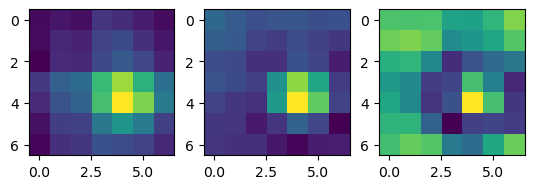

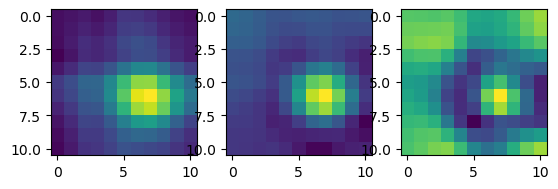

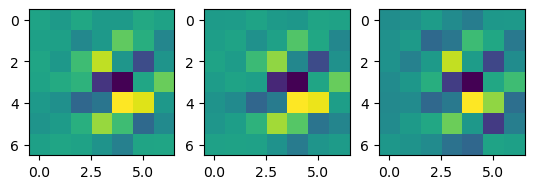

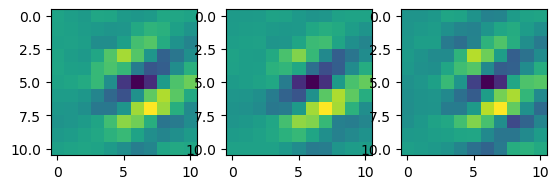

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

model = smp.Unet(encoder_name='resnet34')
#input_weight = model.encoder._conv_stem.weight.detach()#.numpy()
input_weight = model.encoder.conv1.weight.detach()#.numpy()
interpolated_weight = F.interpolate(input_weight, size=(11, 11), mode='bicubic', antialias=True, align_corners=False)

print(input_weight.shape)
print(interpolated_weight.shape)

filter_index = 9
conv_filter = input_weight[filter_index]
interpolated_conv_filter = interpolated_weight[filter_index]
fig1, axs1 = plt.subplots(1,3)
for idx, img in enumerate(conv_filter):
    axs1[idx].imshow(img)

fig2, axs2 = plt.subplots(1,3)
for idx, img in enumerate(interpolated_conv_filter):
    axs2[idx].imshow(img)


filter_index += 1
conv_filter = input_weight[filter_index]
interpolated_conv_filter = interpolated_weight[filter_index]
fig3, axs3 = plt.subplots(1,3)
for idx, img in enumerate(conv_filter):
    axs3[idx].imshow(img)

fig4, axs4 = plt.subplots(1,3)
for idx, img in enumerate(interpolated_conv_filter):
    axs4[idx].imshow(img)


In [36]:
input_weight.shape

torch.Size([32, 3, 3, 3])

# Конфигурации

In [ ]:
unet_config_dict = {
    'segmentation_nn': {
        'nn_architecture': 'unet',
        'params': {
            'encoder_name': "efficientnet-b0",
            'encoder_depth': 5,
            'encoder_weights': "imagenet",
            'decoder_use_norm': "batchnorm",
            'decoder_channels': (256, 128, 128, 128, 128),
            'decoder_attention_type': None,
            'decoder_interpolation': "nearest",
            'in_channels': 3,
            'classes': 11,
            'activation': None,
            'aux_params': None,
        },
        'input_layer_config': {
            'layer_path': 'encoder._conv_stem',
            'replace_type': 'channels+stride',
            'weight_update_type': 'repeate',
            'params':{
                'stride': (1, 1),
                'padding': (1, 1),
                }
        }
    },
    'multispecter_bands_indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'input_image_size': 96,
    'loss': {
        'type': 'crossentropy',
        #'params': {'weight': 'classes'}
        'params': {
            'weight': None,
            'ignore_index': -100,
            'reduction': "mean",
            'label_smoothing': 0.15,
            },
    },
    'optimizer': {
        'type': 'adam',
        'args': {}
    },
    'lr_scheduler': {
        'type': 'cosine_warm_restarts',
        'args': {
            'T_0': 25,
            'T_mult': 1,
            'eta_min': 0,
            'last_epoch': -1
        },
        'params':{
            'interval': 'epoch',
            'frequency': 1,
            'monitor': 'val_loss',
            'strict': True,
            'name': None,
        },
    },
    'device': 'cuda:0',
    'batch_size': 16,
    'path_to_dataset_root': r'C:\Users\admin\python_programming\DATA\DATA_FOR_TRAINIG_96',
    #'path_to_dataset_root': r'C:\Users\mokhail\develop\DATA\DATA_FOR_TRAINIG_96'
}

fpn_config_dict = {
    'segmentation_nn': {
        'nn_architecture': 'custom_fpn',
        'params': {
            'encoder_name': "efficientnet-b0",
            'encoder_depth': 5,
            'encoder_weights': "imagenet",
            'decoder_pyramid_channels': 128,
            'decoder_segmentation_channels': 128,
            'decoder_merge_policy': "add",
            'decoder_dropout': 0.2,
            'decoder_interpolation': "nearest",
            'in_channels': 3,
            'classes': 11,
            'activation': None,
            'upsampling': 0,
            'aux_params': None,
        },
        'input_layer_config': {
            'layer_path': 'encoder._conv_stem',
            'replace_type': 'channels+stride',
            'weight_update_type': 'repeate',
            'params':{
                'stride': (1, 1),
                'padding': (1, 1),
                },
        },
    },
    'multispecter_bands_indices': [1, 2, 3, 7, 'ndvi'],
    'input_image_size': 96,
    'loss': {
        'type': 'crossentropy',
        #'params': {'weight': 'classes'},
        'params': {
            'weight': None,
            'ignore_index': -100,
            'reduction': "mean",
            'label_smoothing': 0.0,
            },
    },
    'optimizer': {
        'type': 'adam',
        'args': {}
    },
    'lr_scheduler': {
        'type': 'cosine_warm_restarts',
        'args': {
            'T_0': 25,
            'T_mult': 1,
            'eta_min': 0,
            'last_epoch': -1
        },
        'params':{
            'interval': 'epoch',
            'frequency': 1,
            'monitor': 'val_loss',
            'strict': True,
            'name': None,
        },
    },
    'device': 'cuda:0',
    'batch_size': 16,
    'path_to_dataset_root': r'C:\Users\admin\python_programming\DATA\DATA_FOR_TRAINIG_96',
    #'path_to_dataset_root': r'C:\Users\mokhail\develop\DATA\DATA_FOR_TRAINIG_96',
}

fcn_config_dict = {
    'segmentation_nn': {
        'nn_architecture': 'fcn',
        'params': {
            'encoder_name': "efficientnet-b0",
            'encoder_depth': 5,
            'encoder_weights': "imagenet",
            'decoder_use_norm': 'batchnorm',
            'decoder_last_channel': 16,
            'decoder_attention_type': None,
            'decoder_interpolation': "nearest",
            'in_channels': 3,
            'classes': 11,
            'activation':  None,
            'aux_params': None,
        },
        'input_layer_config': {
            'layer_path': 'encoder._conv_stem',
            'replace_type': 'channels+stride',
            'weight_update_type': 'repeate',
            'params':{
                'stride': (2, 2),
                'padding': (1, 1),
                },
        },
    },
    'multispecter_bands_indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'input_image_size': 96,
    'loss': {
        'type': 'crossentropy',
        'params': {
            'weight': None,
            'ignore_index': -100,
            'reduction': "mean",
            'label_smoothing': 0.0,
            },
        #'params': {},
    },
    'optimizer': {
        'type': 'adam',
        'args': {}
    },
    'lr_scheduler': {
        'type': 'cosine_warm_restarts',
        'args': {
            'T_0': 25,
            'T_mult': 1,
            'eta_min': 0,
            'last_epoch': -1
        },
        'params':{
            'interval': 'epoch',
            'frequency': 1,
            'monitor': 'val_loss',
            'strict': True,
            'name': None,
        },
    },
    'device': 'cuda:0',
    'batch_size': 16,
    'path_to_dataset_root': r'C:\Users\admin\python_programming\DATA\DATA_FOR_TRAINIG_96',
    #'path_to_dataset_root': r'C:\Users\mokhail\develop\DATA\DATA_FOR_TRAINIG_96',
}

fpn_config_dict_dice_ce = {
    'segmentation_nn': {
        'nn_architecture': 'custom_fpn',
        'params': {
            'encoder_name': "efficientnet-b0",
            'encoder_depth': 5,
            'encoder_weights': "imagenet",
            'decoder_pyramid_channels': 128,
            'decoder_segmentation_channels': 128,
            'decoder_merge_policy': "add",
            'decoder_dropout': 0.2,
            'decoder_interpolation': "nearest",
            'in_channels': 3,
            'classes': 11,
            'activation': None,
            'upsampling': 0,
            'aux_params': None,
        },
        'input_layer_config': {
            'layer_path': 'encoder._conv_stem',
            'replace_type': 'channels+stride',
            'weight_update_type': 'repeate',
            'params':{
                'stride': (1, 1),
                'padding': (1, 1),
                },
        },
    },
    'multispecter_bands_indices': [1, 2, 3, 7, 'ndvi'],
    'input_image_size': 96,
    'loss': {
        'type': 'dice_crossentropy',
        #'params': {'weight': 'classes'},
        'params': {
            'ce_weight':None,
            'ce_ignore_index':-100,
            'ce_reducion':'mean',
            'ce_label_smoothing':0.0,
            'dice_mode':'multiclass',
            'dice_classes': None,
            'dice_log_loss':False,
            'dice_from_logits':True,
            'dice_smooth':0.0,
            'dice_ignore_index':-100,
            'dice_eps': 1e-7,
            'losses_weight': [0.5, 0.5],
            'is_trainable_weights': True,
            'weights_processing_type': 'softmax',
            },
    },
    'optimizer': {
        'type': 'adam',
        'args': {}
    },
    'lr_scheduler': {
        'type': 'cosine_warm_restarts',
        'args': {
            'T_0': 25,
            'T_mult': 1,
            'eta_min': 0,
            'last_epoch': -1
        },
        'params':{
            'interval': 'epoch',
            'frequency': 1,
            'monitor': 'val_loss',
            'strict': True,
            'name': None,
        },
    },
    'device': 'cuda:0',
    'batch_size': 16,
    'path_to_dataset_root': r'C:\Users\admin\python_programming\DATA\DATA_FOR_TRAINIG_96',
    'path_to_dataset_root': r'C:\Users\mokhail\develop\DATA\DATA_FOR_TRAINIG_96',
}

fpn_config_dict_dice = {
    'segmentation_nn': {
        'nn_architecture': 'custom_fpn',
        'params': {
            'encoder_name': "efficientnet-b0",
            'encoder_depth': 5,
            'encoder_weights': "imagenet",
            'decoder_pyramid_channels': 128,
            'decoder_segmentation_channels': 128,
            'decoder_merge_policy': "add",
            'decoder_dropout': 0.2,
            'decoder_interpolation': "nearest",
            'in_channels': 3,
            'classes': 11,
            'activation': None,
            'upsampling': 0,
            'aux_params': None,
        },
        'input_layer_config': {
            'layer_path': 'encoder._conv_stem',
            'replace_type': 'channels+stride',
            'weight_update_type': 'repeate',
            'params':{
                'stride': (1, 1),
                'padding': (1, 1),
                },
        },
    },
    'multispecter_bands_indices': [1, 2, 3, 7, 'ndvi'],
    'input_image_size': 96,
    'loss': {
        'type': 'dice',
        #'params': {'weight': 'classes'},
        'params': {
            'mode':'multiclass',
            'classes': None,
            'log_loss':False,
            'from_logits':True,
            'smooth':0.0,
            'ignore_index':-100,
            'eps': 1e-7,
            },
    },
    'optimizer': {
        'type': 'adam',
        'args': {}
    },
    'lr_scheduler': {
        'type': 'cosine_warm_restarts',
        'args': {
            'T_0': 25,
            'T_mult': 1,
            'eta_min': 0,
            'last_epoch': -1
        },
        'params':{
            'interval': 'epoch',
            'frequency': 1,
            'monitor': 'val_loss',
            'strict': True,
            'name': None,
        },
    },
    'device': 'cuda:0',
    'batch_size': 16,
    'path_to_dataset_root': r'C:\Users\admin\python_programming\DATA\DATA_FOR_TRAINIG_96',
    #'path_to_dataset_root': r'C:\Users\mokhail\develop\DATA\DATA_FOR_TRAINIG_96',
}

fpn_config_dict_ce = {
    'segmentation_nn': {
        'nn_architecture': 'custom_fpn',
        'params': {
            'encoder_name': "efficientnet-b0",
            'encoder_depth': 5,
            'encoder_weights': "imagenet",
            'decoder_pyramid_channels': 128,
            'decoder_segmentation_channels': 128,
            'decoder_merge_policy': "add",
            'decoder_dropout': 0.2,
            'decoder_interpolation': "nearest",
            'in_channels': 3,
            'classes': 11,
            'activation': None,
            'upsampling': 0,
            'aux_params': None,
        },
        'input_layer_config': {
            'layer_path': 'encoder._conv_stem',
            'replace_type': 'channels+stride',
            'weight_update_type': 'repeate',
            'params':{
                'stride': (1, 1),
                'padding': (1, 1),
                },
        },
    },
    'multispecter_bands_indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,],
    'input_image_size': 96,
    'loss': {
        'type': 'crossentropy',
        #'params': {'weight': 'classes'},
        'params': {
            'weight': None,
            'ignore_index': -100,
            'reduction': "mean",
            'label_smoothing': 0.15,
            },
    },
    'optimizer': {
        'type': 'adam',
        'args': {}
    },
    'lr_scheduler': {
        'type': 'cosine_warm_restarts',
        'args': {
            'T_0': 25,
            'T_mult': 1,
            'eta_min': 0,
            'last_epoch': -1
        },
        'params':{
            'interval': 'epoch',
            'frequency': 1,
            'monitor': 'val_loss',
            'strict': True,
            'name': None,
        },
    },
    'device': 'cuda:0',
    'path_to_dataset_root': r'C:\Users\admin\python_programming\DATA\DATA_FOR_TRAINIG_96',
    #'path_to_dataset_root': r'C:\Users\mokhail\develop\DATA\DATA_FOR_TRAINIG_96',
}

fpn_multisize_input_config_dict_ce = {
    'segmentation_nn': {
        'nn_architecture': 'custom_fpn',
        'params': {
            'encoder_name': "efficientnet-b0",
            'encoder_depth': 5,
            'encoder_weights': "imagenet",
            'decoder_pyramid_channels': 128,
            'decoder_segmentation_channels': 128,
            'decoder_merge_policy': "add",
            'decoder_dropout': 0.2,
            'decoder_interpolation': "nearest",
            'in_channels': 3,
            'classes': 11,
            'activation': None,
            'upsampling': 0,
            'aux_params': None,
        },
        'input_layer_config': {
            'layer_path': 'encoder._conv_stem',
            'replace_type': 'channels+stride',
            'weight_update_type': 'repeate',
            'params':{
                'in_channels': 3,
                'out_channels': {
                    '1x1': 32,
                    '3x3': 32,
                    '5x5': 32, 
                },
                'kernel_size': {
                    '1x1': 1,
                    '3x3': 3,
                    '5x5': 5, 
                },
                'stride': {
                    '1x1': 1,
                    '3x3': 1,
                    '5x5': 1, 
                },
                'padding': {
                    '1x1': 0,
                    '3x3': 1,
                    '5x5': 2, 
                },
                'dilation': {
                    '1x1': 1,
                    '3x3': 1,
                    '5x5': 1, 
                },
                'groups': {
                    '1x1': 1,
                    '3x3': 1,
                    '5x5': 1, 
                },
                'bias': {
                    '1x1': False,
                    '3x3': False,
                    '5x5': False, 
                },
                'aggregation_type': 'add',
            },
        },
    },
    'multispecter_bands_indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,],
    'input_image_size': 96,
    'loss': {
        'type': 'crossentropy',
        #'params': {'weight': 'classes'},
        'params': {
            'weight': None,
            'ignore_index': -100,
            'reduction': "mean",
            'label_smoothing': 0.15,
            },
    },
    'optimizer': {
        'type': 'adam',
        'args': {}
    },
    'lr_scheduler': {
        'type': 'cosine_warm_restarts',
        'args': {
            'T_0': 25,
            'T_mult': 1,
            'eta_min': 0,
            'last_epoch': -1
        },
        'params':{
            'interval': 'epoch',
            'frequency': 1,
            'monitor': 'val_loss',
            'strict': True,
            'name': None,
        },
    },
    'device': 'cuda:0',
    'batch_size': 16,
    'path_to_dataset_root': r'C:\Users\admin\python_programming\DATA\DATA_FOR_TRAINIG_96',
    #'path_to_dataset_root': r'C:\Users\mokhail\develop\DATA\DATA_FOR_TRAINIG_96',
}

fpn_mit_config_dict_ce = {
    'segmentation_nn': {
        'nn_architecture': 'custom_fpn',
        'params': {
            'encoder_name': "mit_b0",
            'encoder_depth': 5,
            'encoder_weights': "imagenet",
            'decoder_pyramid_channels': 128,
            'decoder_segmentation_channels': 128,
            'decoder_merge_policy': "add",
            'decoder_dropout': 0.2,
            'decoder_interpolation': "nearest",
            'in_channels': 3,
            'classes': 11,
            'activation': None,
            'upsampling': 0,
            'aux_params': None,
        },
        'input_layer_config': {
            'layer_path': 'encoder._conv_stem',
            'replace_type': 'channels+stride',
            'weight_update_type': 'repeate',
            'params':{
                'stride': (1, 1),
                'padding': (1, 1),
                },
        },
    },
    'multispecter_bands_indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,],
    'input_image_size': 96,
    'loss': {
        'type': 'crossentropy',
        #'params': {'weight': 'classes'},
        'params': {
            'weight': None,
            'ignore_index': -100,
            'reduction': "mean",
            'label_smoothing': 0.15,
            },
    },
    'optimizer': {
        'type': 'adam',
        'args': {}
    },
    'lr_scheduler': {
        'type': 'cosine_warm_restarts',
        'args': {
            'T_0': 25,
            'T_mult': 1,
            'eta_min': 0,
            'last_epoch': -1
        },
        'params':{
            'interval': 'epoch',
            'frequency': 1,
            'monitor': 'val_loss',
            'strict': True,
            'name': None,
        },
    },
    'device': 'cuda:0',
    'batch_size': 16,
    'path_to_dataset_root': r'C:\Users\admin\python_programming\DATA\DATA_FOR_TRAINIG_96',
    #'path_to_dataset_root': r'C:\Users\mokhail\develop\DATA\DATA_FOR_TRAINIG_96',
}

config_dict = fpn_multisize_input_config_dict_ce
config_dict


{'segmentation_nn': {'nn_architecture': 'custom_fpn',
  'params': {'encoder_name': 'efficientnet-b0',
   'encoder_depth': 5,
   'encoder_weights': 'imagenet',
   'decoder_pyramid_channels': 128,
   'decoder_segmentation_channels': 128,
   'decoder_merge_policy': 'add',
   'decoder_dropout': 0.2,
   'decoder_interpolation': 'nearest',
   'in_channels': 3,
   'classes': 11,
   'activation': None,
   'upsampling': 0,
   'aux_params': None},
  'input_layer_config': {'layer_path': 'encoder._conv_stem',
   'replace_type': 'channels+stride',
   'weight_update_type': 'repeate',
   'params': {'in_channels': 3,
    'out_channels': {'1x1': 32, '3x3': 32, '5x5': 32},
    'kernel_size': {'1x1': 1, '3x3': 3, '5x5': 5},
    'stride': {'1x1': 1, '3x3': 1, '5x5': 1},
    'padding': {'1x1': 0, '3x3': 1, '5x5': 2},
    'dilation': {'1x1': 1, '3x3': 1, '5x5': 1},
    'groups': {'1x1': 1, '3x3': 1, '5x5': 1},
    'bias': {'1x1': False, '3x3': False, '5x5': False},
    'aggregation_type': 'add'}}},
 'multis

In [32]:
model = FPNMod(encoder_name='mit_b0', image_size=(96, 96))
model(torch.randn(1, 3, 96, 96)).shape

c:\Users\admin\miniconda3\envs\deep_learning\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


RuntimeError: The size of tensor a (256) must match the size of tensor b (0) at non-singleton dimension 1

In [25]:
conv = MultisizeConv(**config_dict['segmentation_nn']['input_layer_config']['params'])
conv(torch.randn(1, 3, 112, 112)).shape

torch.Size([1, 32, 112, 112])

In [72]:
model = smp.Unet()
model.get_submodule('encoder.layer1.0.conv1')

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

# Создание модели

In [ ]:
path_to_dataset_root = config_dict['path_to_dataset_root']

path_to_dataset_info_csv = os.path.join(path_to_dataset_root, 'data_info_table.csv')
path_to_surface_classes_json = os.path.join(path_to_dataset_root, 'surface_classes.json')

input_image_size = config_dict['input_image_size']
multispecter_bands_indices = config_dict['multispecter_bands_indices']
device = config_dict['device']

# чтение списка имен классов поверхностей
with open(path_to_surface_classes_json) as fd:
    surface_classes_list = json.load(fd)
# чтение таблицы с информацией о каждом изображении в выборке
images_df = pd.read_csv(path_to_dataset_info_csv)

path_to_partition_json = os.path.join(path_to_dataset_root, 'dataset_partition.json')
# чтение словаря со списками квадратов, находящихся в обучающей и тестовой выборке
with open(path_to_partition_json) as fd:
    partition_dict = json.load(fd)

# формирование pandas DataFrame-ов с информацией об изображениях обучающей и тестовой выборках
train_images_df = []
for train_square in partition_dict['train_squares']:
    train_images_df.append(images_df[images_df['square_id']==train_square])
train_images_df = pd.concat(train_images_df, ignore_index=True)

test_images_df = []
for test_square in partition_dict['test_squares']:
    test_images_df.append(images_df[images_df['square_id']==test_square])
test_images_df = pd.concat(test_images_df, ignore_index=True)

#train_images_df, test_images_df = train_test_split(images_df, test_size=0.3, random_state=0)

class_num = images_df['class_num'].iloc[0]

# формирование словаря, отображающейго имя класса поверхности в индекс класса
class_name2idx_dict = {n:i for i, n in enumerate(surface_classes_list)}

# вычисление распределений пикселей в классах поверхностей 
classes_pixels_distribution_df = images_df[surface_classes_list]
classes_pixels_num = classes_pixels_distribution_df.sum()
classes_weights = classes_pixels_num / classes_pixels_num.sum()
classes_weights = classes_weights[surface_classes_list].to_numpy().astype(np.float32)

input_image_size = config_dict['input_image_size']
'''
train_transforms = v2.Compose(
    [v2.Resize((input_image_size,input_image_size), antialias=True),v2.ToDtype(torch.float32, scale=True)])
test_transforms = v2.Compose(
    [v2.Resize((input_image_size,input_image_size), antialias=True),v2.ToDtype(torch.float32, scale=True)])
'''
train_transforms = nn.Identity()
test_transforms = nn.Identity()
# если ф-ция потерь перекрестная энтропия, то проверяем, есть ли там веса классов
if config_dict['loss']['type'] == 'crossentropy':
    # если в параметрах функции потерь стоит строка 'classes', надо передать в функцию вектор весов классов
    if 'weight' in config_dict['loss']['params']:
        if isinstance(config_dict['loss']['params']['weight'], (list, tuple)):
            config_dict['loss']['params']['weight'] = torch.tensor(config_dict['loss']['params']['weight'])
        
        elif config_dict['loss']['params']['weight'] is not None:
            config_dict['loss']['params']['weight'] = torch.tensor(classes_weights)

# создание функции потерь
criterion = criterion_factory_dict[config_dict['loss']['type']](**config_dict['loss']['params'])

# если ф-ция потерь перекрестная энтропия, то проверяем, есть ли там веса классов
if config_dict['loss']['type'] == 'crossentropy':
    # если в параметрах функции потерь стоит строка 'classes', надо передать в функцию вектор весов классов
    if 'weight' in config_dict['loss']['params']:
        if isinstance(config_dict['loss']['params']['weight'], torch.Tensor):
            config_dict['loss']['params']['weight'] = config_dict['loss']['params']['weight'].cpu().tolist()

model = create_model(config_dict, segmentation_nns_factory_dict)
model = model.to(device)

# создаем датасеты и даталоадеры
train_dataset = SegmentationDataset(path_to_dataset_root=path_to_dataset_root, samples_df=train_images_df, channel_indices=multispecter_bands_indices, transforms=train_transforms, dtype=torch.float32, device=device)
test_dataset = SegmentationDataset(path_to_dataset_root=path_to_dataset_root, samples_df=test_images_df, channel_indices=multispecter_bands_indices, transforms=test_transforms, dtype=torch.float32, device=device)
#train_dataset = SegmentationDatasetApplSurf(path_to_dataset_root=path_to_dataset_root, samples_df=test_images_df, channel_indices=channel_indices, name2class_idx_dict=class_name2idx_dict, applicable_surfaces_dict=applicable_surfaces_dict, transforms=test_transforms, device=device)
#test_dataset = SegmentationDatasetApplSurf(path_to_dataset_root=path_to_dataset_root, samples_df=test_images_df, channel_indices=channel_indices, name2class_idx_dict=class_name2idx_dict, applicable_surfaces_dict=applicable_surfaces_dict, transforms=test_transforms, device=device)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config_dict['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config_dict['batch_size'])

# тестовое чтение данных
for data, labels in test_loader:
    break
    pred = model(data)
    loss = criterion(pred, labels)
    loss.backward()
    

# тестовая обработка данных нейронной сетью
ret = model(data)
print(data.shape, ret.shape)

createion_time_str = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
nn_arch_str = config_dict["segmentation_nn"]["nn_architecture"]
nn_encoder_str = config_dict["segmentation_nn"]["params"]["encoder_name"]
model_name = f'{nn_arch_str}_{nn_encoder_str} {createion_time_str}'
model_name

torch.Size([16, 13, 96, 96]) torch.Size([16, 11, 96, 96])


'unet_efficientnet-b0 2025-09-08-19-44-49'

# Обучение

In [62]:
epoch_num = 150

print('#############################')
print(model_name)
print('#############################')
print()

# создаем список словарей с информацией о вычисляемых метриках с помощью multiclass confusion matrix
# см. подробнее ддокументацию к функции compute_metric_from_confusion
metrics_dict = {
    'train': {
        'iou': classification.JaccardIndex(task='multiclass', average='none', num_classes=len(class_name2idx_dict)).to(device),
        'precision': classification.Precision(task='multiclass', average='none', num_classes=len(class_name2idx_dict)).to(device),
        'recall': classification.Precision(task='multiclass', average='none', num_classes=len(class_name2idx_dict)).to(device),
        #'confusion': classification.ConfusionMatrix(task='multiclass', num_classes=len(class_name2idx_dict)).to(device),
    },
    'val': {
        'iou': classification.JaccardIndex(task='multiclass', average='none', num_classes=len(class_name2idx_dict)).to(device),
        'precision': classification.Precision(task='multiclass', average='none', num_classes=len(class_name2idx_dict)).to(device),
        'recall': classification.Precision(task='multiclass', average='none', num_classes=len(class_name2idx_dict)).to(device),
        #'confusion': classification.ConfusionMatrix(task='multiclass', num_classes=len(class_name2idx_dict)).to(device),
    }
}

optimizer_cfg = {
    'optmizer': optimizers_factory_dict[config_dict['optimizer']['type']],
    'optimizer_args':config_dict['optimizer']['args'],
    'lr_scheduler': lr_schedulers_factory_dict[config_dict['lr_scheduler']['type']],
    'lr_scheduler_args': config_dict['lr_scheduler']['args'],
    'lr_scheduler_params': config_dict['lr_scheduler']['params']

}

# Создаем модуль Lightning
segmentation_module = SegmentationModule(model, criterion, optimizer_cfg, metrics_dict, class_name2idx_dict)

# задаем путь до папки с логгерами и создаем логгер, записывающий результаты в csv
path_to_saving_dir = 'saving_dir'
csv_logger = CSVLogger(
    save_dir = path_to_saving_dir,
    name=model_name, 
    flush_logs_every_n_steps=1,
    )

# создаем объект, записывающий в чекпоинт лучшую модель
path_to_save_model_dir = os.path.join(path_to_saving_dir, model_name)
os.makedirs(path_to_save_model_dir, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    mode="max",
    filename=model_name+"-{epoch:02d}-{val_iou_mean:.3}",
    dirpath=path_to_save_model_dir, 
    save_top_k=1, monitor="val_iou_mean"
    )

trainer = L.Trainer(logger=[csv_logger],
        max_epochs=epoch_num, 
        callbacks=[checkpoint_callback],
        accelerator = 'gpu'
        )

# сохраняем конфигурацию
path_to_config = os.path.join(path_to_save_model_dir, 'training_config.yaml')
with open(path_to_config, 'w', encoding='utf-8') as fd:
    #json.dump(config_dict, fd, indent=4)
    yaml.dump(config_dict, fd, indent=4)

trainer.fit(segmentation_module , train_loader, test_loader)

#############################
unet_efficientnet-b0 2025-09-08-19-44-49
#############################



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\admin\miniconda3\envs\deep_learning\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\admin\python_programming\MultispectralSegmentation\saving_dir\unet_efficientnet-b0 2025-09-08-19-44-49 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Unet             | 7.0 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
28.196    Total estimated model params size (MB)
324       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\admin\miniconda3\envs\deep_learning\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


c:\Users\admin\miniconda3\envs\deep_learning\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 149: 100%|██████████| 106/106 [00:36<00:00,  2.89it/s, v_num=0, val_loss=1.300, val_iou_UNLABELED=0.859, val_iou_buildings_territory=0.721, val_iou_natural_ground=0.203, val_iou_natural_grow=0.184, val_iou_natural_wetland=0.416, val_iou_natural_wood=0.794, val_iou_quasi_natural_ground=0.0409, val_iou_quasi_natural_grow=0.475, val_iou_quasi_natural_wetland=0.454, val_iou_transport=0.338, val_iou_water=0.863, val_iou_mean=0.486, val_precision_UNLABELED=0.953, val_precision_buildings_territory=0.851, val_precision_natural_ground=0.531, val_precision_natural_grow=0.381, val_precision_natural_wetland=0.643, val_precision_natural_wood=0.834, val_precision_quasi_natural_ground=0.143, val_precision_quasi_natural_grow=0.643, val_precision_quasi_natural_wetland=0.822, val_precision_transport=0.587, val_precision_water=0.935, val_precision_mean=0.666, val_recall_UNLABELED=0.953, val_recall_buildings_territory=0.851, val_recall_natural_ground=0.531, val_recall_natural_grow=0.381, val_recall_

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 106/106 [00:36<00:00,  2.88it/s, v_num=0, val_loss=1.300, val_iou_UNLABELED=0.859, val_iou_buildings_territory=0.721, val_iou_natural_ground=0.203, val_iou_natural_grow=0.184, val_iou_natural_wetland=0.416, val_iou_natural_wood=0.794, val_iou_quasi_natural_ground=0.0409, val_iou_quasi_natural_grow=0.475, val_iou_quasi_natural_wetland=0.454, val_iou_transport=0.338, val_iou_water=0.863, val_iou_mean=0.486, val_precision_UNLABELED=0.953, val_precision_buildings_territory=0.851, val_precision_natural_ground=0.531, val_precision_natural_grow=0.381, val_precision_natural_wetland=0.643, val_precision_natural_wood=0.834, val_precision_quasi_natural_ground=0.143, val_precision_quasi_natural_grow=0.643, val_precision_quasi_natural_wetland=0.822, val_precision_transport=0.587, val_precision_water=0.935, val_precision_mean=0.666, val_recall_UNLABELED=0.953, val_recall_buildings_territory=0.851, val_recall_natural_ground=0.531, val_recall_natural_grow=0.381, val_recall_

In [22]:
path_to_config = 'training_config.yaml'
with open(path_to_config, 'w', encoding='utf-8') as fd:
    #json.dump(config_dict, fd, indent=4)
    yaml.dump(config_dict, fd, indent=4)

In [12]:
logger.log_dir

'saving_dir\\unet++_efficientnet-b0 2025-09-07-02-29-35\\version_0'